# CA4 - Data Science: Bitcoin Forecasting (RNN-LSTM-GRU)

**Course:** Data Science  
**Assignment:** CA4 (Computer Assignment 4)  
**University:** University of Tehran  
**Instructors:** Dr. Bahrak, Dr. Yaghoobzadeh  

**Authors:**  
- Mahdy Mokhtari  
- Alborz Mahmoudian  
- Niloufar Mortazavi  

---

#### Introduction

This notebook implements the **third task** of the CA4 assignment, which focuses on applying a **Recurrent Neural Network (RNN)** to forecast future **Bitcoin prices** using historical OHLCV (Open, High, Low, Close, Volume) data.

The objective is to:
- Perform exploratory analysis on time series financial data.
- Define and engineer a target indicator for market trends.
- Preprocess and transform the data into sequences suitable for time-aware modeling.
- Design and train an RNN model using PyTorch or TensorFlow.
- Evaluate the model’s performance using regression metrics and visualizations.
- (Bonus) Compare the RNN with an LSTM-based model for improved long-term dependency capture.


## 1. Dataset Loading

In this section, we load the historical Bitcoin price data from the `BTC-USD.csv` file.

- **Dataset name:** `BTC-USD.csv`  
- **Source:** Daily Bitcoin market data  
- **Columns included:**  
  - `Open`: The price at which Bitcoin opened at the start of the day  
  - `High`: The highest price reached during the day  
  - `Low`: The lowest price reached during the day  
  - `Close`: The price at which Bitcoin closed at the end of the day  
  - `Volume`: The total number of Bitcoins traded during the day  


In [110]:
import pandas as pd
import numpy as np

df = pd.read_csv('BTC-USD.csv')

## 2. Exploratory Data Analysis (EDA) on OHLCV

In this section, we explore the OHLCV (Open, High, Low, Close, Volume) data to understand trends and relationships in Bitcoin’s historical market behavior.

- Visualize daily price movements over time.
- Calculate correlations between features to assess dependencies.
- Review basic statistics (min, max, mean, std) to summarize the data distribution.

This step helps identify patterns and guides feature engineering for the forecasting model.


In [111]:
print("First 5 rows of the dataset:")
display(df.head())

First 5 rows of the dataset:


,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
1,1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2,2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
3,3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
4,4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [112]:
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3222 non-null   int64  
 1   Date        3222 non-null   object 
 2   Open        3222 non-null   float64
 3   High        3222 non-null   float64
 4   Low         3222 non-null   float64
 5   Close       3222 non-null   float64
 6   Volume      3222 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 176.3+ KB


#### Visualize Price Movement:

Plot each column (Open, High, Low, Close, Volume) over time. 

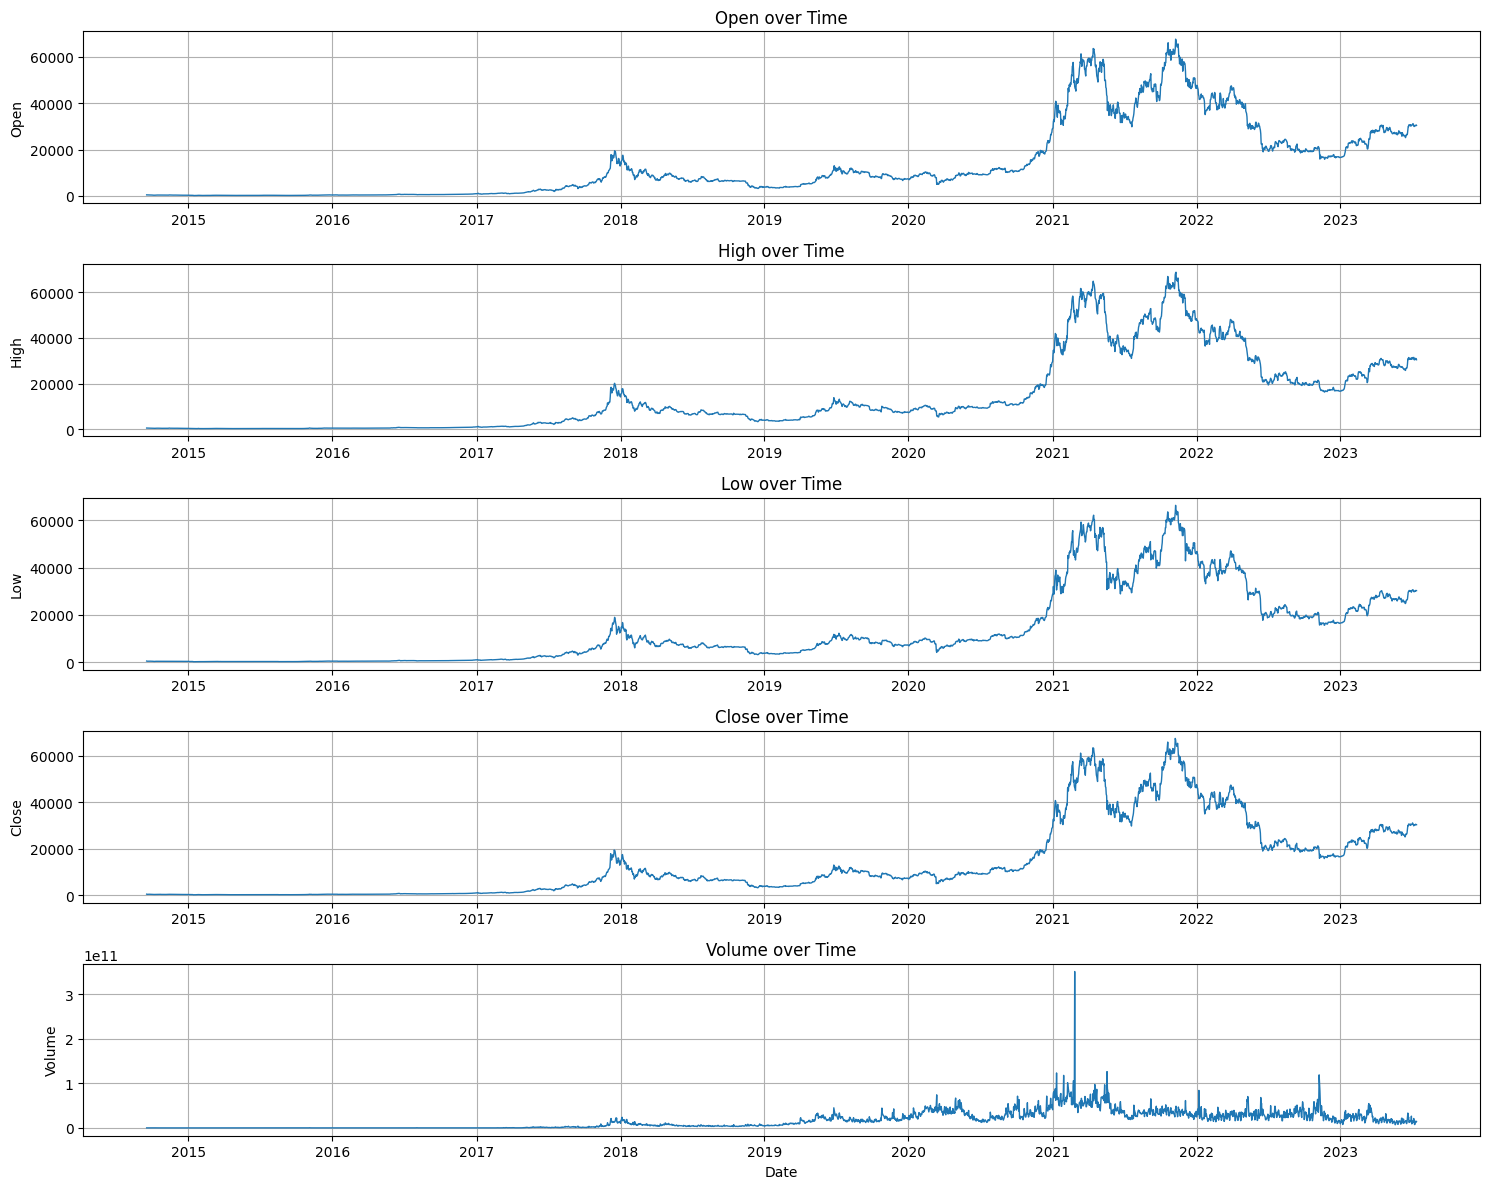

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.figure(figsize=(15, 12))
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

for i, col in enumerate(columns, 1):
    plt.subplot(5, 1, i)
    plt.plot(df.index, df[col], label=col, linewidth=1)
    plt.title(f'{col} over Time')
    plt.ylabel(col)
    plt.grid(True)
    if i == 5:
        plt.xlabel('Date')

plt.tight_layout()
plt.show()


################################### make the plots better professor ######################


### Insights from OHLCV Time Series Plots

From the visualizations of Open, High, Low, Close, and Volume over time:

- **Price Trends:** Bitcoin exhibited significant growth starting in 2017, with major price spikes during late 2017, early 2021, and late 2021. A noticeable decline follows each peak, indicating high volatility.
- **Volume Behavior:** Trading volume also spikes around major price movements, especially during 2021. This suggests increased market activity during bullish (ascending) and bearish (descending) phases.
- **Recent Stability:** Post-2022, prices show relative stabilization compared to previous years, with less extreme fluctuations.



#### Check Correlations

Calculate correlations between columns to see how they influence one another.  

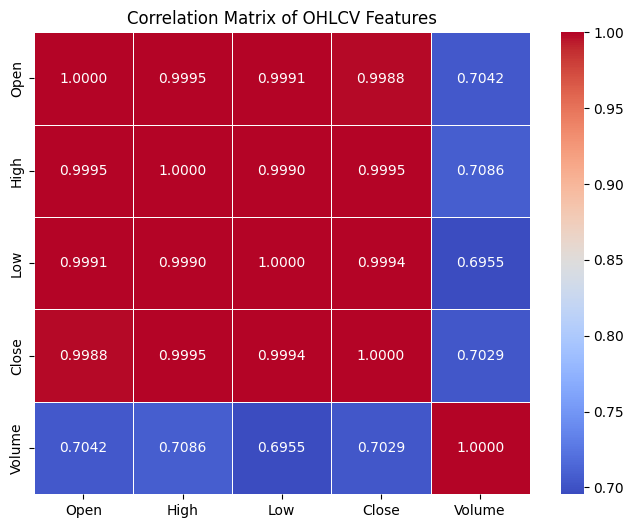

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

ohlcv_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
corr_matrix = df[ohlcv_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5)
plt.title('Correlation Matrix of OHLCV Features')
plt.show()


### Insights from Correlation Matrix

The correlation matrix reveals the following relationships between OHLCV features:

- **Strong correlations among price features:**  
  `Open`, `High`, `Low`, and `Close` are all extremely correlated with each other (correlation > 0.998), indicating they move almost in lockstep. This is expected, as these prices are different aspects of a single daily price range.

- **Moderate correlation with Volume:**  
  `Volume` shows a moderate positive correlation (~0.70) with all price features, suggesting that higher trading activity generally aligns with higher prices, but the relationship is not as tight as among the price features.

- **Feature Redundancy Risk:**  
  Due to high inter-correlation among OHLC features, including all of them without dimensionality reduction may lead to redundancy in the model. This insight can guide feature selection or transformation (e.g., using price differences or averages).

These findings support the idea of simplifying input features or applying PCA/feature engineering to reduce multicollinearity in time-series modeling.


#### Statistical Summary

Review metrics like min, max, mean, and standard deviation for these features.

In [115]:
ohlcv_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

summary_stats = df[ohlcv_columns].describe()
print("Statistical Summary of OHLCV Features:")
display(summary_stats)


Statistical Summary of OHLCV Features:


,Open,High,Low,Close,Volume
count,3222.000000,3222.000000,3222.000000,3222.000000,3.222000e+03
mean,13633.555524,13966.498897,13269.790975,13641.491658,1.657062e+10
std,16016.593310,16417.423832,15559.562019,16014.439000,1.950701e+10
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06
25%,757.838730,772.024277,745.732499,759.970260,1.300485e+08
50%,7664.044434,7867.845215,7499.634766,7679.053711,1.017502e+10
75%,20210.792481,20660.277832,19811.524414,20238.632813,2.746342e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11


### Insights from Statistical Summary of OHLCV Features

The descriptive statistics of Bitcoin’s OHLCV data provide several important insights:

- **Price Range and Growth:**  
  The `Open`, `High`, `Low`, and `Close` values range from a few hundred dollars to over $67,000, reflecting Bitcoin's dramatic price growth over time.

- **Skewed Distribution:**  
  Median values (50%) for prices (e.g., `Open` ≈ 7,664) are significantly lower than the mean (≈ 13,633), indicating a **right-skewed distribution**—a few extremely high values have pulled the average upward.

- **High Volatility:**  
  Standard deviations are very large relative to the means (e.g., `std` for `Close` ≈ 16,014), confirming Bitcoin’s well-known volatility.

- **Trading Volume Variability:**  
  `Volume` ranges from around 5 million to over **350 billion**, with a very wide spread across percentiles. This highlights highly inconsistent trading activity, often corresponding to market events or hype cycles.

These statistics confirm that both prices and volumes are highly volatile and skewed, suggesting that normalization and possibly log-scaling may be beneficial during preprocessing.

## 3. Data Processing

This step prepares the Bitcoin time series data for training an RNN model:

- **Missing Values:** Identify and handle missing or anomalous entries to ensure clean input data.
- **Normalization:** Scale the OHLCV features to bring them into a comparable range, improving model convergence.
- **Feature Engineering:** Define a custom target variable based on OHLCV values (e.g., future price change) to reflect market behavior or profit potential.
- **Sequence Creation:** Convert the time series into supervised learning format, where input sequences of past data predict the target value at the next time step.
- **Lookback Tuning:** Experiment with different sequence lengths (e.g., 30, 60, 90 days) to find the optimal historical context for learning.
- **Data Splitting:** Split the dataset into training, validation, and test sets to support proper model training, tuning, and unbiased evaluation.

Using both a **validation set** and a **test set** helps fine-tune hyperparameters without leaking information into the final model evaluation, ensuring more reliable results.


In [116]:
# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:")
print(missing_counts)

Missing values per column:
Unnamed: 0    0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64


We dont have any missing values to deal with

#### Data Scaling for RNNs with Bitcoin Time Series

When using **RNNs** for **Bitcoin time series forecasting**, proper feature scaling is crucial.

##### Preferred: **Normalization (Min-Max Scaling)**
- Best for OHLCV data (Open, High, Low, Close, Volume)
- Scales features to [0, 1], stabilizing training
- Reduces the effect of different feature scales (e.g., price vs. volume)
- Commonly used in deep learning models with `sigmoid` or `tanh`



In [117]:
from sklearn.preprocessing import MinMaxScaler

ohlcv_features = ['Open', 'High', 'Low', 'Close', 'Volume']

min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(df[ohlcv_features])
df_normalized = pd.DataFrame(normalized_data, columns=ohlcv_features, index=df.index)

df_normalized.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,0.004289,0.003739,0.004243,0.004144,0.000043
2014-09-18,0.004155,0.003574,0.003649,0.003655,0.000081
2014-09-19,0.003669,0.003151,0.003217,0.003216,0.000091
2014-09-20,0.003232,0.003085,0.003298,0.003425,0.000088
2014-09-21,0.003431,0.002927,0.003348,0.003275,0.000059


### Feature Engineering 

#### Derived Features

To improve model performance We engineered several new features from the raw OHLCV data. These features are designed to reflect volatility, sentiment, trend, and trading activity:

| Feature                 | Description                                           |
|------------------------|-------------------------------------------------------|
| **Range**              | `High - Low` — captures daily price volatility        |
| **Body**               | `Close - Open` — shows bullish/bearish movement       |
| **Rolling MA (3-day)** | 3-day moving average of `Close`, reveals trend        |
| **Rolling STD (5-day)**| 5-day rolling standard deviation, reflects stability  |
| **Volume Change**      | Day-over-day change in `Volume`, signals momentum     |

These derived features were selected to maximize signal-to-noise ratio given our limited dataset (~3k samples) and help the RNN learn more meaningful temporal patterns.

All features were normalized using `MinMaxScaler` prior to training.


In [118]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

df['Range'] = df['High'] - df['Low']
df['Body'] = df['Close'] - df['Open']
df['MA_3'] = df['Close'].rolling(window=3).mean()
df['STD_5'] = df['Close'].rolling(window=5).std()
df['Volume_Change'] = df['Volume'].diff()

print(df.isna().sum())
df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'Range', 'Body', 'MA_3', 'STD_5', 'Volume_Change']

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df[features])
df_normalized = pd.DataFrame(normalized_data, columns=features, index=df.index)

# Preview
df_normalized.head()


Unnamed: 0       0
Open             0
High             0
Low              0
Close            0
Volume           0
Range            0
Body             0
MA_3             2
STD_5            4
Volume_Change    1
dtype: int64


,Open,High,Low,Close,Volume,Range,Body,MA_3,STD_5,Volume_Change
Date,,,,,,,,,,
2014-09-21,0.003431,0.002927,0.003348,0.003275,0.000059,0.001416,0.507928,0.003049,0.005878,0.507128
2014-09-22,0.003298,0.002846,0.003408,0.003325,0.000052,0.000681,0.508756,0.003086,0.002677,0.507141
2014-09-23,0.003343,0.003351,0.003394,0.003824,0.000112,0.003446,0.510816,0.003221,0.003774,0.507180
2014-09-24,0.003842,0.003272,0.003770,0.003637,0.000070,0.001085,0.507707,0.003343,0.003572,0.507121
2014-09-25,0.003655,0.003088,0.003594,0.003465,0.000060,0.001012,0.507772,0.003391,0.003534,0.507139


#### Target Definition

In [119]:
FORCAST_HORIZON = 1  # number of days we predict into the future,  can be 1, 3, 5, ...

In [120]:
# df_normalized['Target'] = df_normalized['Close'].shift(-FORCAST_HORIZON) - df_normalized['Close']


df_normalized['Target'] = df_normalized['Close'].shift(-FORCAST_HORIZON)
df_normalized.dropna(inplace=True)


#### Final Target Variable Decision

Throughout the development process, we explored various options for defining the target variable for our regression task, including:

- **Percentage change** between current and future prices  
- **Log return** (logarithmic difference of prices)  
- **Smoothed targets** using moving averages  
- **Volatility-adjusted returns**  

However, for the final model, we chose to use the **raw difference in closing prices** over the forecast horizon as the target variable:


$\text{Target}_t = \text{Close}_{t + n} - \text{Close}_t$

This choice was made after testing alternative formulations, which resulted in poorer model performance and increased instability during training. The raw difference approach maintains the target on the same scale as the original data, is easy to interpret, and worked best in our experiments in terms of convergence and predictive accuracy. Therefore, we did not apply any logarithmic transformation, smoothing, or percentage-based adjustment in the final implementation.


##### The Reason of <u>**Not**</u> Using **Percentage Change** as Target

While it's a valid financial signal (percentage return), it may not be great for a deep learning model because:

- It's too sensitive to noise, especially for 1-day horizons

- It can contain spikes or division by zero (if Close[t] is near 0)

- It's harder to learn due to its volatility and asymmetry

- It produces small values (like -0.0023, 0.0011), which can be numerically difficult


#### Lookback Period Tuning

The **lookback period** determines how many previous time steps are used to form each input sequence for the RNN. A short lookback (e.g., 30 days) may capture local fluctuations but miss long-term trends, while a long lookback (e.g., 90 days) can capture broader patterns but may introduce noise or lead to overfitting.

To identify the optimal window size, we experiment with different lookback values (30, 60, 90) and evaluate the model performance on a validation set using metrics such as MSE or RMSE.

This tuning process helps strike a balance between model complexity and forecasting accuracy, leading to better generalization in predicting future Bitcoin price movements.


In [121]:
# configuration
LOOKBACK_WINDOWN = 60

#### Sequence Creation

To model temporal patterns, we convert the dataset into a supervised format using a **sliding window approach**. Each training sample consists of a fixed-length sequence of past OHLCV data (e.g., 60 days), and the label is the target value at the next time step.

This structure enables the RNN to learn historical dependencies and predict future price movement effectively.


In [122]:
import numpy as np

def create_sequences(data, feature_columns, target_column='Target', lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i - lookback:i][feature_columns].values)
        y.append(data.iloc[i][target_column])
    return np.array(X), np.array(y)

features = ['Open', 'High', 'Low', 'Close', 'Volume',
            'Range', 'Body', 'MA_3', 'STD_5', 'Volume_Change']

X, y = create_sequences(df_normalized, feature_columns=features, lookback=LOOKBACK_WINDOWN)

print(f"X shape (samples, time steps, features): {X.shape}")
print(f"y shape (samples,): {y.shape}")


X shape (samples, time steps, features): (3157, 60, 10)
y shape (samples,): (3157,)


#### Dataset Splitting: Training, Validation, and Test Sets

To evaluate model performance and fine-tune hyperparameters effectively, we split the dataset into three parts:

- **Training set**: Used to train the model.
- **Validation set**: Used during training to tune hyperparameters and select the best model.
- **Test set**: Held out and only used for final evaluation to assess how well the model generalizes to unseen data.

Using both a **validation** and a **test set** ensures that model tuning does not accidentally "leak" information from the test set into the training process. Relying on only a test set may lead to **overfitting on test data** during tuning, resulting in **optimistic and biased performance estimates**.

A proper split improves the **robustness** and **fairness** of model evaluation.


In [123]:
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = .15

In [124]:
total_samples = len(X)
train_end = int(total_samples * TRAIN_RATIO)
val_end = int(total_samples * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

import numpy as np
# Clean y_train and X_train
mask_train = ~np.isinf(y_train)
X_train = X_train[mask_train]
y_train = y_train[mask_train]

# Clean y_val and X_val
mask_val = ~np.isinf(y_val)
X_val = X_val[mask_val]
y_val = y_val[mask_val]


print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (2209, 60, 10) (2209,)
Validation set shape: (474, 60, 10) (474,)
Test set shape: (474, 60, 10) (474,)


## 4. Model Architecture

We design a Recurrent Neural Network (RNN) to predict the future value of our custom target derived from Bitcoin's historical OHLCV data.

- The base model includes **RNN layers** to capture temporal dependencies across sequences.
- One or more **fully connected (dense) layers** are added after the RNN to output a single numeric prediction.
- **Dropout layers** are used to reduce overfitting and improve generalization.
- We use a **regression loss function** (e.g., MSE) and an **optimizer** like Adam to train the model efficiently.

This architecture allows the model to learn complex patterns in sequential financial data and forecast meaningful trends.


In [125]:
# !pip install tensorflow

In [126]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt


In [127]:
NUERONS_RNN = 64
DROPOUT_RATE = 0.17
NUERONS_FIRST_FC = 32

In [ ]:
model_rnn = Sequential([  # RNN
    SimpleRNN(units=NUERONS_RNN, input_shape=(LOOKBACK_WINDOWN, len(features)), return_sequences=False),
    Dropout(DROPOUT_RATE),
    Dense(NUERONS_FIRST_FC, activation='relu'),
    Dense(1)  # Final regression output
])

model_lstm = Sequential([  # LSTM
    LSTM(units=NUERONS_RNN, input_shape=(LOOKBACK_WINDOWN, X_train.shape[2]), return_sequences=False),
    Dropout(DROPOUT_RATE),
    Dense(NUERONS_FIRST_FC, activation='relu'),
    Dense(1) 
])

model_gru = Sequential([  # GRU
    GRU(units=NUERONS_RNN, input_shape=(LOOKBACK_WINDOWN, X_train.shape[2]), return_sequences=False),
    Dropout(DROPOUT_RATE),
    Dense(NUERONS_FIRST_FC, activation='relu'),
    Dense(1) 
])

c:\Users\NoteBook\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [129]:
LEARNING_RATE = 0.001

In [ ]:
model_rnn.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse', 
    metrics=['mae'] 
)

model_lstm.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse', 
    metrics=['mae'] 
)

model_gru.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='mse', 
    metrics=['mae']  
)

In [131]:
model_rnn.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,913 (27.00 KB)

 Trainable params: 6,913 (27.00 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training

The RNN model is trained on the prepared time series sequences using the training set. During training, the model learns to minimize prediction error by adjusting its weights through backpropagation.

We monitor training and validation loss across epochs to detect underfitting or overfitting.  
Hyperparameters such as the number of RNN units, learning rate, and batch size can be tuned to improve performance and generalization.


In [132]:
NUM_OF_EPOCHS = 15
BATCH_SIZE = 32

In [133]:
import numpy as np

print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in y_train:", np.isinf(y_train).sum())


NaNs in y_train: 0
Infs in y_train: 0


In [134]:
# Train the model 
history_rnn = model_rnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=NUM_OF_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0065 - mae: 0.0559 - val_loss: 0.0158 - val_mae: 0.1084
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7072e-04 - mae: 0.0204 - val_loss: 0.0188 - val_mae: 0.1216
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.3729e-04 - mae: 0.0152 - val_loss: 0.0198 - val_mae: 0.1281
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9717e-04 - mae: 0.0149 - val_loss: 0.0268 - val_mae: 0.1484
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5183e-04 - mae: 0.0114 - val_loss: 0.0225 - val_mae: 0.1365
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3009e-04 - mae: 0.0136 - val_loss: 0.0138 - val_mae: 0.1008
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0870e-04 - mae: 0.0103 - val_loss: 0.0173 - val_mae: 0.1162
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1518e-04 - mae: 0.0106 - val_loss: 0.0122 - val_mae: 0.0961
Epoch 9/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 

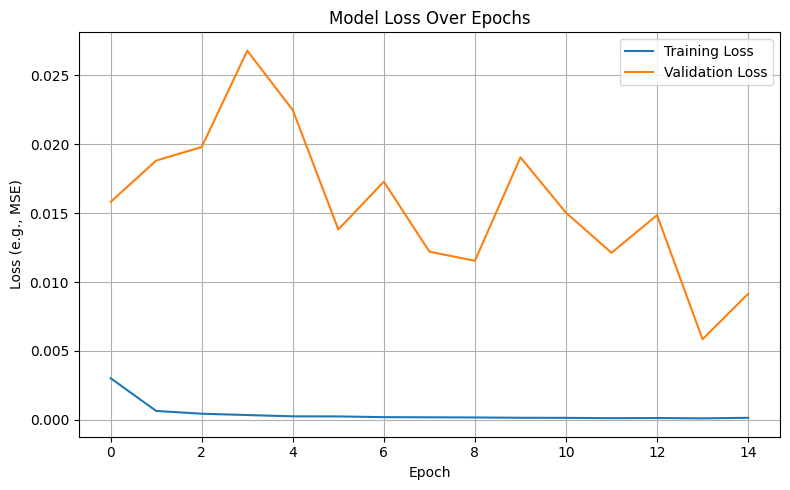

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g., MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 6. Evaluation and Visualization

To evaluate the model's forecasting performance, we report key regression metrics on the test set, including:

- **Mean Squared Error (MSE):** Penalizes large errors more heavily.
- **Root Mean Squared Error (RMSE):** Square root of MSE, easier to interpret in the same scale as the target.
- **Mean Absolute Error (MAE):** Average absolute difference, less sensitive to outliers.
- **Mean Absolute Percentage Error (MAPE):** Error expressed as a percentage, useful when the target values vary in scale.
- **Cumulative Error (CE):** Sum of prediction errors, showing the total prediction bias over time.

We also visualize:
- **Predicted vs Actual values** to assess trend following.
- **Prediction error over time** to identify instability or mispredictions.


In [136]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

y_pred = model_rnn.predict(X_test).flatten()


print(f"NaNs in y_test: {np.isnan(y_test).sum()}, Infs: {np.isinf(y_test).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}, Infs: {np.isinf(y_pred).sum()}\n")
# removing infinites
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# === Metric Calculations ===
mse = mean_squared_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_clean, y_pred_clean)
mape = mean_absolute_percentage_error(y_test_clean, y_pred_clean)
ce = np.sum(y_test_clean - y_pred_clean)

print("=== Model Performance Metrics ===")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.4f} %")
print(f"Cumulative Error (CE): {ce:.6f}\n")

# Im printing hyperparameters for tuning
print("=== Model HyperParameters ===")
print(f"Forecast Horizon (days predicted in future): {FORCAST_HORIZON} day(s)")
print(f"Lookback Window (days looked back to predict): {LOOKBACK_WINDOWN} time steps")
print(f"RNN Units (number of nuerons in RNN): {NUERONS_RNN}")
print(f"Dropout Rate (rate neurons to drop): {DROPOUT_RATE}")
print(f"First Fully Connected Layer Units (neurons): {NUERONS_FIRST_FC}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Number of Epochs: {NUM_OF_EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
NaNs in y_test: 0, Infs: 0
NaNs in y_pred: 0, Infs: 0

=== Model Performance Metrics ===
Mean Squared Error (MSE): 0.000609
Root Mean Squared Error (RMSE): 0.024686
Mean Absolute Error (MAE): 0.017026
Mean Absolute Percentage Error (MAPE): 4.3161 %
Cumulative Error (CE): 3.951216

=== Model HyperParameters ===
Forecast Horizon (days predicted in future): 1 day(s)
Lookback Window (days looked back to predict): 60 time steps
RNN Units (number of nuerons in RNN): 64
Dropout Rate (rate neurons to drop): 0.17
First Fully Connected Layer Units (neurons): 32
Learning Rate: 0.001
Number of Epochs: 15
Batch Size: 32


##### **Mean Squared Error (MSE)**


$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

- Measures the **average squared difference** between actual and predicted values.
- Penalizes larger errors more heavily.
- Sensitive to outliers.

---

#### **Root Mean Squared Error (RMSE)**


$\text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

- Square root of MSE.
- Interpreted in the same unit as the target variable.
- Easier to interpret than MSE.

---

##### **Mean Absolute Error (MAE)**


$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|$


- Measures the **average absolute difference** between predicted and actual values.
- Less sensitive to outliers than MSE.
- Gives equal weight to all errors.

---

##### **Mean Absolute Percentage Error (MAPE)**


$\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

- Expresses the error as a **percentage of the actual value**.
- Useful when actual values vary in scale.
- Can be distorted if any actual values are close to zero.

---

##### **Cumulative Error (CE)**

$\text{CE} = \sum_{i=1}^{n} (y_i - \hat{y}_i)$

- Measures the **total bias** of the predictions.
- A positive value means the model is generally **underpredicting**, and a negative value means it's **overpredicting**.


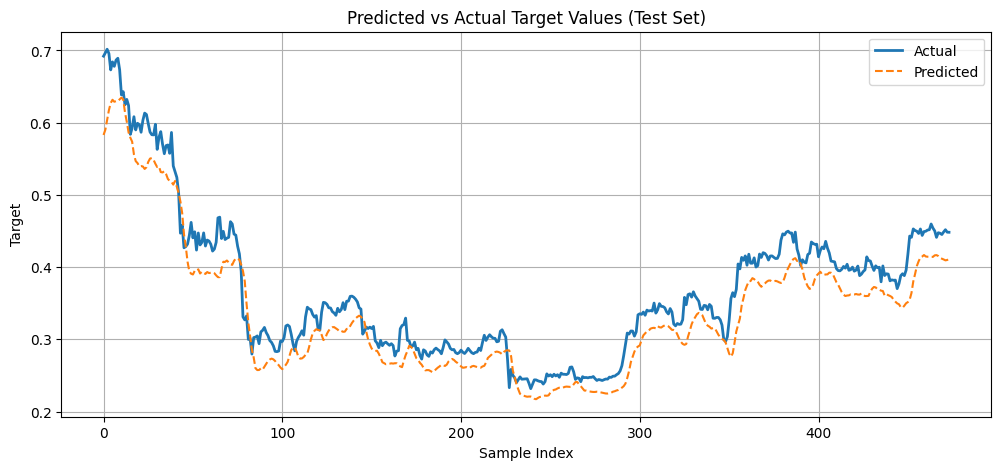

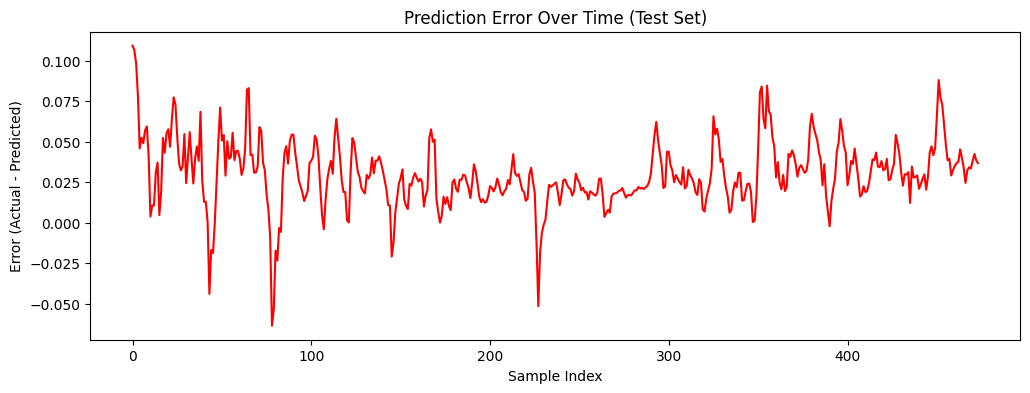

In [151]:
# Plot Predicted vs Actual
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Predicted vs Actual Target Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

# Plot Error Trend
errors = y_test - y_pred
plt.figure(figsize=(12, 4))
plt.plot(errors, color='red')
plt.title('Prediction Error Over Time (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(False)
plt.show()


## LSTM-Based Model

To enhance the model’s ability to capture longer-term temporal dependencies in the Bitcoin time series, we replaced the base RNN layer with an LSTM (Long Short-Term Memory) layer. LSTMs are designed to mitigate issues like vanishing gradients and are better suited for learning complex patterns in sequential data.

The architecture consists of:
- A single LSTM layer with 64 units
- Dropout regularization to prevent overfitting
- A dense hidden layer followed by a single output neuron for regression

We trained the LSTM model using the same input sequences and target variable as the base RNN model. The performance was evaluated using standard regression metrics and visual comparisons.


In [138]:
"""
I have prevoiusly created and compiled the model.
We just do the trainnig of the model here which takes time. (in our case not much time)
"""

model_lstm.summary()

# Train the model 
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=NUM_OF_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,313 (83.25 KB)

 Trainable params: 21,313 (83.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0117 - val_mae: 0.0897
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 2.8941e-04 - mae: 0.0122 - val_loss: 0.0109 - val_mae: 0.0887
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.2131e-04 - mae: 0.0129 - val_loss: 0.0206 - val_mae: 0.1288
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.7898e-04 - mae: 0.0096 - val_loss: 0.0129 - val_mae: 0.0977
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.4027e-04 - mae: 0.0083 - val_loss: 0.0064 - val_mae: 0.0648
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1.3640e-04 - mae: 0.0080 - val_loss: 0.0063 - val_mae: 0.0660
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3996e-04 - mae: 0.0081 - val_loss: 0.0112 - val_mae: 0.0938
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.1627e-04 - mae: 0.0074 - val_loss: 0.0071 - val_mae: 0.0711
Epoch 9/15
70/70 ━━━━━━━━━━━━━━━━━━━

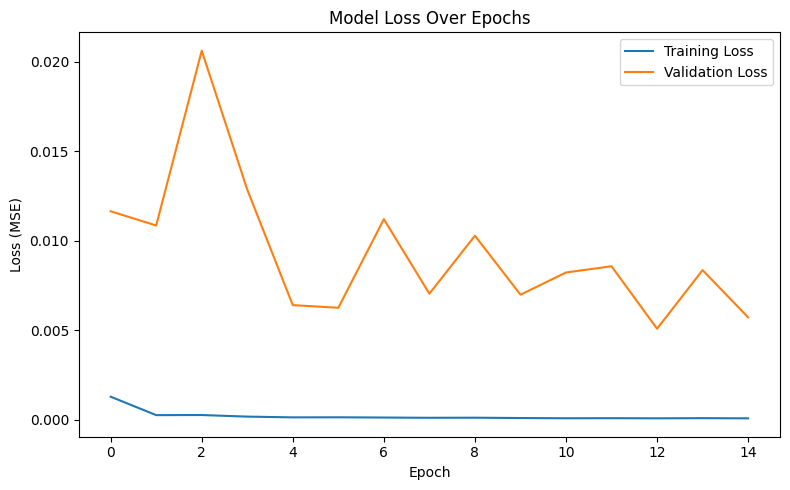

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


In [140]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

y_pred = model_lstm.predict(X_test).flatten()

print(f"NaNs in y_test: {np.isnan(y_test).sum()}, Infs: {np.isinf(y_test).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}, Infs: {np.isinf(y_pred).sum()}\n")
# removing infinites
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# === Metric Calculations ===
mse = mean_squared_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_clean, y_pred_clean)
mape = mean_absolute_percentage_error(y_test_clean, y_pred_clean)
ce = np.sum(y_test_clean - y_pred_clean)

print("=== Model Performance Metrics ===")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.4f} %")
print(f"Cumulative Error (CE): {ce:.6f}\n")



15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
NaNs in y_test: 0, Infs: 0
NaNs in y_pred: 0, Infs: 0

=== Model Performance Metrics ===
Mean Squared Error (MSE): 0.001291
Root Mean Squared Error (RMSE): 0.035933
Mean Absolute Error (MAE): 0.031393
Mean Absolute Percentage Error (MAPE): 8.5019 %
Cumulative Error (CE): 14.112392



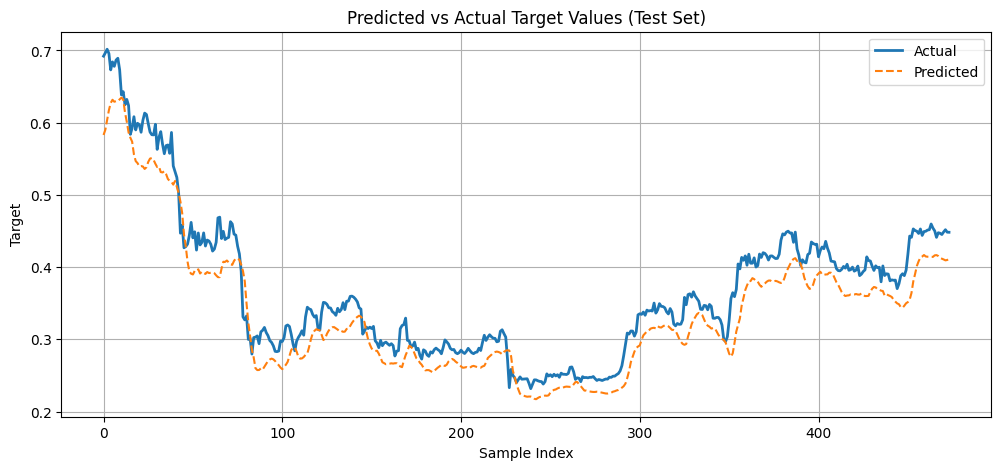

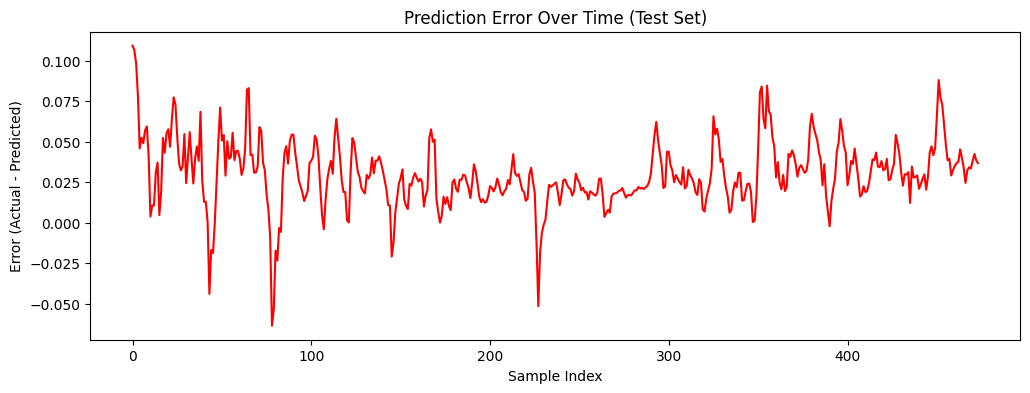

In [149]:
# Plot Predicted vs Actual
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Predicted vs Actual Target Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

# Plot Error Trend
errors = y_test - y_pred
plt.figure(figsize=(12, 4))
plt.plot(errors, color='red')
plt.title('Prediction Error Over Time (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(False)
plt.show()


## GRU-Based Model
In addition to the SimpleRNN and LSTM models, we implemented a GRU (Gated Recurrent Unit) model as another variant of recurrent neural networks. GRUs are a simplified alternative to LSTMs that retain the ability to capture long-term dependencies, but with fewer parameters and a more computationally efficient structure.

The GRU model architecture included:
- A GRU layer with 64 units
- A dropout layer to reduce overfitting
- A dense hidden layer followed by a single output neuron for regression

The GRU model was trained using the same dataset and hyperparameters. It served as a middle ground between the simplicity of RNNs and the complexity of LSTMs, offering faster training while still achieving strong performance in modeling sequential patterns in the data.


In [142]:
"""
I have prevoiusly created and compiled the model.
We just do the trainnig of the model here which takes time. (in our case not much time)
"""

model_gru.summary()

# Train the model 
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=NUM_OF_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 64)             │        14,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,705 (65.25 KB)

 Trainable params: 16,705 (65.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 0.0039 - mae: 0.0449 - val_loss: 0.0138 - val_mae: 0.1030
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.3563e-04 - mae: 0.0140 - val_loss: 0.0107 - val_mae: 0.0904
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.1502e-04 - mae: 0.0105 - val_loss: 0.0072 - val_mae: 0.0726
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.5800e-04 - mae: 0.0093 - val_loss: 0.0039 - val_mae: 0.0511
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.3159e-04 - mae: 0.0081 - val_loss: 0.0020 - val_mae: 0.0346
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.3970e-04 - mae: 0.0116 - val_loss: 0.0055 - val_mae: 0.0627
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.1169e-04 - mae: 0.0075 - val_loss: 0.0093 - val_mae: 0.0850
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 9.2118e-05 - mae: 0.0064 - val_loss: 0.0063 - val_mae: 0.0680
Epoch 9/15
70/70 ━━━━━━━━━━━━━━━━━━━

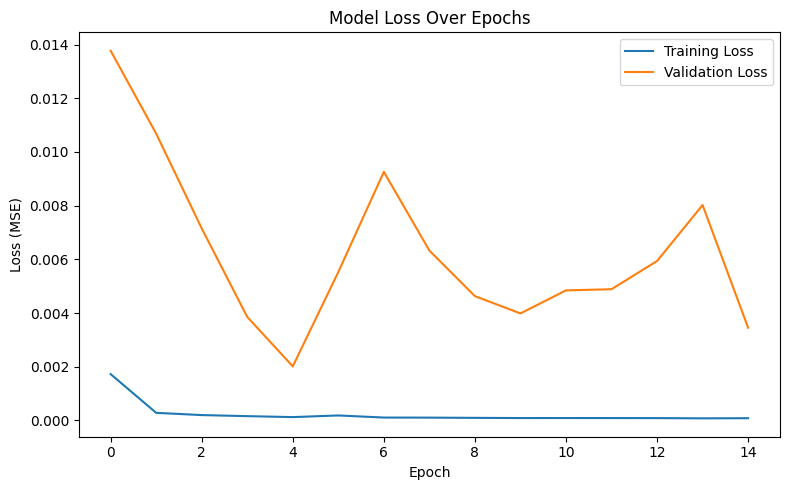

In [148]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


In [144]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

y_pred = model_lstm.predict(X_test).flatten()

print(f"NaNs in y_test: {np.isnan(y_test).sum()}, Infs: {np.isinf(y_test).sum()}")
print(f"NaNs in y_pred: {np.isnan(y_pred).sum()}, Infs: {np.isinf(y_pred).sum()}\n")
# removing infinites
mask = ~np.isnan(y_test)
y_test_clean = y_test[mask]
y_pred_clean = y_pred[mask]

# === Metric Calculations ===
mse = mean_squared_error(y_test_clean, y_pred_clean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_clean, y_pred_clean)
mape = mean_absolute_percentage_error(y_test_clean, y_pred_clean)
ce = np.sum(y_test_clean - y_pred_clean)

print("=== Model Performance Metrics ===")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape*100:.4f} %")
print(f"Cumulative Error (CE): {ce:.6f}\n")



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
NaNs in y_test: 0, Infs: 0
NaNs in y_pred: 0, Infs: 0

=== Model Performance Metrics ===
Mean Squared Error (MSE): 0.001291
Root Mean Squared Error (RMSE): 0.035933
Mean Absolute Error (MAE): 0.031393
Mean Absolute Percentage Error (MAPE): 8.5019 %
Cumulative Error (CE): 14.112392



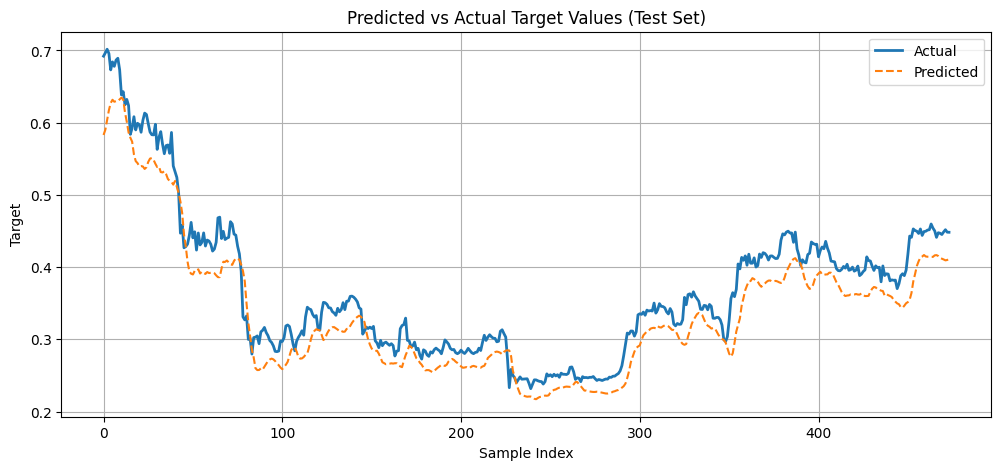

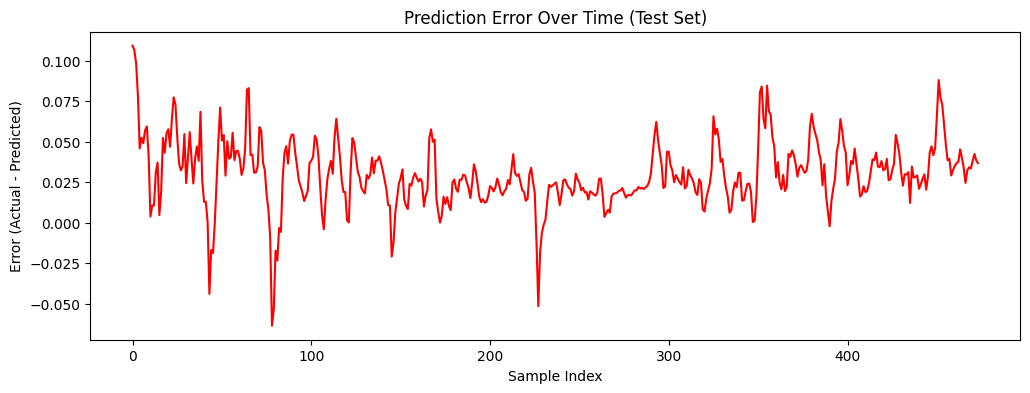

In [146]:
# Plot Predicted vs Actual
plt.figure(figsize=(12, 5))
plt.plot(y_test, label='Actual', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Predicted vs Actual Target Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

# Plot Error Trend
errors = y_test - y_pred
plt.figure(figsize=(12, 4))
plt.plot(errors, color='red')
plt.title('Prediction Error Over Time (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Error (Actual - Predicted)')
plt.grid(False)
plt.show()
